In [38]:
#### ---- Self-adaptive weighted filter to remove GAUSSIAN & IMPULSIVE noise in INFRARED images ---- ####

## for color images

In [39]:
import numpy as np
import cv2
import os
from scipy import signal
from skimage import io, color
from matplotlib import pyplot as plt
import math
from skimage.filters import sobel

window_size = 3
W = window_size//2
poz_median=window_size*window_size//2

T1 = 80 # for differences values between pixels
T2 = 3 # for number of pixels in window
nucleu = np.ones((3,3))/9.0
VALID_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif', '.webp')

In [40]:
# MSE

def MSE(imgref, imgzg):
    # problema cu int si float
    # diferenta poata fi negativa (se da peste cap) -> normalizam

    MSE = np.sum((imgzg - imgref)**2)/np.prod(np.shape(imgref))
    
    # MSE normalizat
    sumval = np.sum(imgref**2)
    NMSE = MSE/sumval

    return MSE, NMSE

In [41]:
# add gaussian noise to a color image

def add_gaussian_noise(img, disp):
      
   zg = np.random.normal(0,disp,np.shape(img))
   img_zg = img + zg
   # e posibil ca unele valori sa iasa din gama [0,255]
   img_zg = np.clip(img_zg, a_min = 0, a_max =255)
   
   return np.uint8(img_zg)

In [42]:
# sare si piper

def add_impulsive_noise(img, procent_negru, procent_alb):
   
   [L,C, pl] = np.shape(img)
   nr_pixeli_zero = int(L*C*procent_negru)
   nr_pixeli_unu = int(L*C*procent_alb)

   for plan_curent in range(pl):
    numere_intregi_L = np.random.randint(0,L, nr_pixeli_zero)
    numere_intregi_C = np.random.randint(0,C, nr_pixeli_zero)
    img[numere_intregi_L, numere_intregi_C, plan_curent] = 0

    numere_intregi_L = np.random.randint(0,L, nr_pixeli_unu)
    numere_intregi_C = np.random.randint(0,C, nr_pixeli_unu)
    img[numere_intregi_L, numere_intregi_C, plan_curent] = 1

   return np.uint8(img)

In [43]:
def bordare_imagine(img):

    [L,C,pl] = np.shape(img)
    [d1, d2] = np.shape(nucleu)

    kernel = np.zeros((d1+1, d2+1))
    kernel[d1//2,d2//2] = 1

    Ybordered = np.zeros((L+d1,C+d2,pl))
    for pl in range(0,3):
        Ybordered[:,:,pl] = signal.convolve2d(img[:,:,pl], kernel, mode='full', boundary='symm')

    return np.uint8(Ybordered)

In [44]:
def display_image(image, title, filename):
    plt.figure()
    plt.imshow(image)
    plt.title(f"{title}: \n {os.path.basename(filename)}")
    plt.show()


In [45]:
def file_is_image(folder_path):
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)

        if filename.lower().endswith(VALID_EXTENSIONS):
            process_image(filepath)

# TODO

In [46]:
# calcul T1 - (40,90) si T2 - (0,8)

def compute_thresholds(image):
    """
    Compute thresholds based on image details.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        tuple: A tuple containing two thresholds (threshold1, threshold2).
    """
    if image is None:
        raise ValueError("Image not found or invalid image format.")

    # Calculate edge density using Canny edge detection
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size

    # Calculate variance of pixel intensity
    intensity_variance = np.var(image)

    # Normalize metrics to a range of 0 to 1
    normalized_edge_density = min(1, edge_density / 0.1)  # Assume 0.1 is high edge density
    normalized_intensity_variance = min(1, intensity_variance / 5000)  # Adjust 5000 based on experimentation

    # Combine metrics to estimate image details (weights can be adjusted)
    detail_level = 0.7 * normalized_edge_density + 0.3 * normalized_intensity_variance

    # Scale thresholds based on detail level
    threshold1 = 40 + detail_level * (90 - 40)
    threshold2 = 1 + detail_level * (8 - 1)

    return round(threshold1), round(threshold2)

In [47]:
# ajuta la calculul lui T1, T2 cu metoda a doua

def compute_image_detail_metrics(image):
    """
    Compute metrics for evaluating image detail.

    Parameters:
        image (numpy.ndarray): Grayscale image array.

    Returns:
        tuple: Edge density, intensity variance, entropy, gradient mean.
    """
    # Edge Density
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size

    # Intensity Variance
    intensity_variance = np.var(image)

    # Entropy
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256], density=True)
    entropy = -np.sum(histogram * np.log2(histogram + 1e-9))

    # Gradient Magnitude (using Sobel filter)
    gradient = sobel(image)
    gradient_mean = np.mean(gradient)

    return edge_density, intensity_variance, entropy, gradient_mean

In [48]:
# calcul T1 - (40,90) si T2 - (0,8) 
# varianta 2

def compute_thresholds_alt_variant(image):
    """
    Compute thresholds based on image details.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        tuple: A tuple containing two thresholds (threshold1, threshold2).
    """

    if image is None:
        raise ValueError("Image not found or invalid image format.")

    # Compute image detail metrics
    edge_density, intensity_variance, entropy, gradient_mean = compute_image_detail_metrics(image)

    # Normalize metrics to a range of 0 to 1
    normalized_edge_density = min(1, edge_density / 0.1)  # Assume 0.1 is high edge density
    normalized_intensity_variance = min(1, intensity_variance / 5000)  # Adjust 5000 based on experimentation
    normalized_entropy = min(1, entropy / 8)  # Assume max entropy is around 8
    normalized_gradient = min(1, gradient_mean / 0.5)  # Assume 0.5 is high gradient mean

    # Combine metrics to estimate detail level (weights can be adjusted)
    detail_level = (0.3 * normalized_edge_density +
                    0.3 * normalized_intensity_variance +
                    0.2 * normalized_entropy +
                    0.2 * normalized_gradient)

    # Scale thresholds based on detail level
    threshold1 = 40 + detail_level * (90 - 40)
    threshold2 = 0 + detail_level * (8 - 0)

    return round(threshold1), round(threshold2)

In [49]:
# calcul ponderi pentru filtrul median / de medie

def calculate_weights(flattened_window, diff):
    """Calculate adaptive weights for a filter window."""

    differences = np.abs(flattened_window - diff)
    weights = 1/(1+differences**2)
    normalized_weights = weights/np.sum(weights)

    return normalized_weights

In [50]:
# filtru gaussian normal (de comparat)

def normal_mean_filter(img):
    
    [d1, d2] = np.shape(nucleu)
    kernel = np.zeros((d1+1, d2+1))
    kernel[d1//2,d2//2] = 1

    [L,C,pl] = np.shape(img)
    imgout = np.zeros((L,C,pl))

    for pl in range(0,3):

        Ybordered = signal.convolve2d(img[:,:,pl], kernel, mode='full', boundary='symm')
        for l in range(0,L):
            for c in range(0,C):
                imgout[l,c,pl] = np.sum(nucleu*Ybordered[l:l+d1, c:c+d2])

    return np.uint8(imgout)

In [51]:
# filtru median normal (de comparat)

def normal_median_filter(img):
    contor_zgomot = 0

    """Apply the median filter."""
    # nucleu 3x3
    [d1, d2] = np.shape(nucleu)
    kernel = np.zeros((d1+1, d2+1))
    kernel[d1//2,d2//2] = 1

    [L,C,pl] = np.shape(img)
    imgout = np.zeros((L,C,pl))
    Ybordered = bordare_imagine(img)

    for pl in range(0,3):
        for l in range(0,L):
            for c in range(0,C):

                val_selectate = Ybordered[l:l+d1, c:c+d2,pl]
                val_sortate = np.sort(val_selectate.flatten())
                mijloc = val_sortate[d1*d2//2]
                imgout[l,c,pl] = mijloc

    return np.uint8(imgout)

In [52]:
### Window filter functions for grayscale images (un plan de culoare) ###

def gaussian_filter_in_window_1colorplan(window):
    # 3x3 window
    mean = np.mean(window)
    weights = calculate_weights(window, mean)

    centered_pixel = np.sum(weights*window[:,:])  

    return np.round(centered_pixel)  

#####################################################

def impulsive_filter_in_window_1colorplan(window):
    # 3x3 window
    val_sortate = np.sort(window)
    val_sortate = val_sortate[1:len(val_sortate)-1]

    middle_val = val_sortate[len(val_sortate)//2]
    weights = calculate_weights(val_sortate, middle_val)
    
    centered_pixel = np.sum(weights*window[1:len(window)-1]) 

    return np.round(centered_pixel)

In [53]:
# functie care aplica filtrul descris in articol pentru zgomot gaussian si impulsiv
# returneaza imaginea filtrara si numarul de pixeli cu zgomot gaussian, impulsiv si nemodificati

def compute_image_adaptive_weighted_filter(img_noise_color, T1, T2):
    gaussian_counter = 0
    impulsive_counter = 0
    normal_counter = 0

    [L,C,pl]=np.shape(img_noise_color)
    Ybordat = bordare_imagine(img_noise_color) 
    imgout = np.zeros(np.shape(img_noise_color))
    
    for p in range(0,pl):
        for l in range(0,L):
            for c in range(0,C):
                
                # extract window and center pixel
                val_selectate = Ybordat[l-W+W:l+W+1+W,c-W+W:c+W+1+W,p] # shiftez cu W
                l1,c1 = np.shape(val_selectate)
                centered_pixel = val_selectate[l1//2, c1//2]

                # calcualate differences between center and the rest of pixels from window
                differences = np.abs(val_selectate - centered_pixel)
                
                # Count neighbors with differences greater than T1
                N = np.sum(differences > T1)
                
                # Classify noise and filter accordingly
                if N == 0:
                    imgout[l,c,p] = gaussian_filter_in_window_1colorplan(val_selectate) # gaussian - mean filter
                    # print("gauss: col {0}, linia {1}".format(l,c))
                    gaussian_counter+=1
                elif N > T2:
                    imgout[l,c,p] = impulsive_filter_in_window_1colorplan(val_selectate) # impulsive - median filter
                    # print("impulsive: col {0}, linia {1}".format(l,c))
                    impulsive_counter+=1
                else: 
                    imgout[l,c,p] = centered_pixel
                    # print("normal: col {0}, linia {1}".format(l,c))
                    normal_counter+=1

    return np.uint8(imgout), gaussian_counter, impulsive_counter, normal_counter

# pathname = 'Images\\1.jpg'
# img = io.imread(pathname)

# # add gaussian noise


# # # Apply the self-adaptive weighted gaussian filter
# filtered_image_gauss = normal_mean_filter(img_noise_gauss)
# display_image(filtered_image_gauss, 'Img filtrata cu medie', pathname)

# T1 = 60
# T2 = 5
# imgout, gaussian_counter, impulsive_counter, normal_counter = compute_image_adaptive_weighted_filter(img_noise_gauss, T1, T2)
# display_image(imgout, 'Img filtrata adaptiv in fereastra', pathname)

In [55]:
def compute_image_choosing_filter_and_noise_type(img, noise_img, filter_type, noise_type):
    """
    Compute image based on filter type (normal/adaptiv) and noise type (gaussian/impulsiv/gaussian_impulsiv)

    Parameters:
        noise_img : Image with noise
        filter_type (str): type of filter from those 2 applied
        noise type (str): type of noise from image (can be both)

    Returns:
        imgout: Filtered image
    """
    if np.shape(img)[2] > 3:
        print("original image has also transparency \nsize was {1}".format(np.shape(img)))
        img=img[:,:,:3]

    if noise_type == 'gaussian':
        if filter_type == 'normal':

            imgout = normal_mean_filter(noise_img)
            return imgout
        
        elif filter_type == 'adaptiv':

            T1, T2 = compute_thresholds_alt_variant(img)
            imgout,_,_,_ = compute_image_adaptive_weighted_filter(noise_img, T1, T2)
            return imgout
        
    elif noise_type == 'impulsiv':
        if filter_type == 'normal':

            imgout = normal_median_filter(noise_img)
            return imgout
        
        elif filter_type == 'adaptiv':

            T1, T2 = compute_thresholds_alt_variant(img)
            imgout,_,_,_ = compute_image_adaptive_weighted_filter(noise_img, T1, T2)
            return imgout


    elif noise_type == 'gaussian_impulsiv':

        T1, T2 = compute_thresholds_alt_variant(img)
        imgout,_,_,_ = compute_image_adaptive_weighted_filter(noise_img, T1, T2)
        return imgout
    
    else: 
        return "Something went wrong!"  


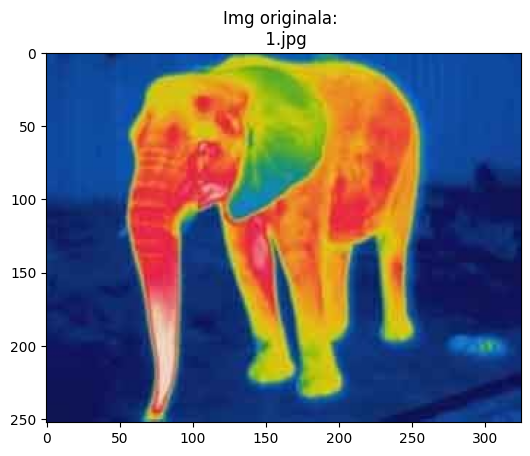

(253, 325, 3)


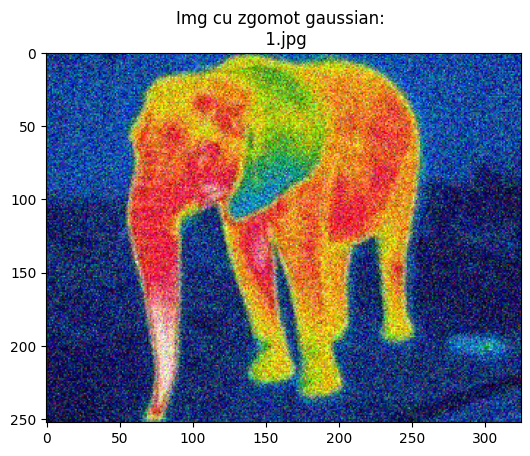

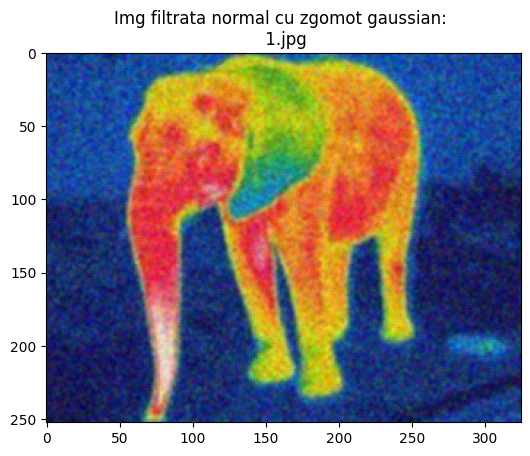

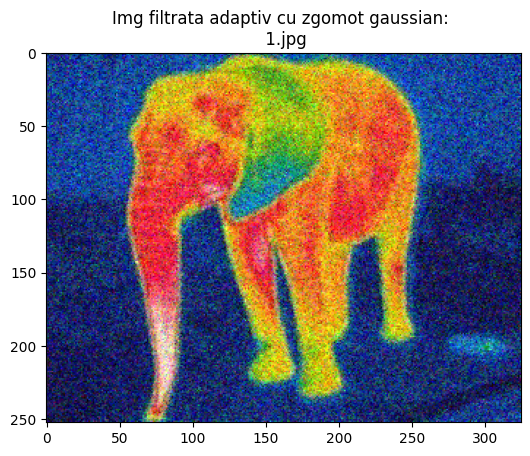

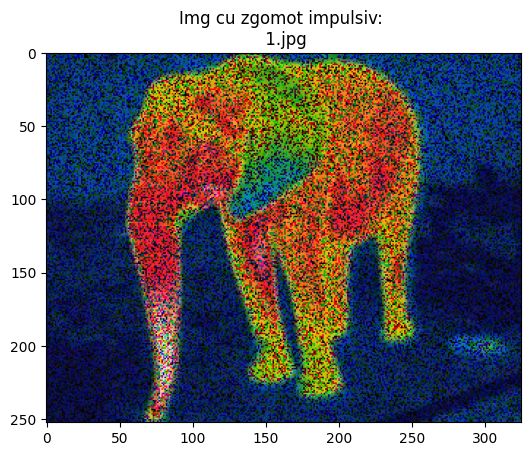

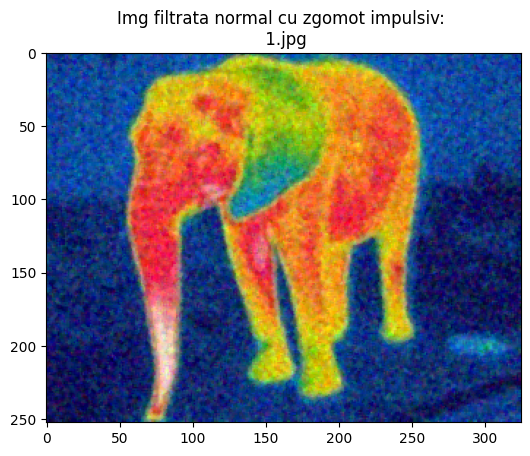

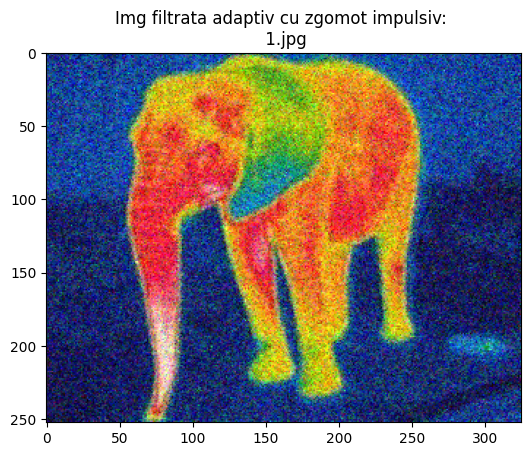

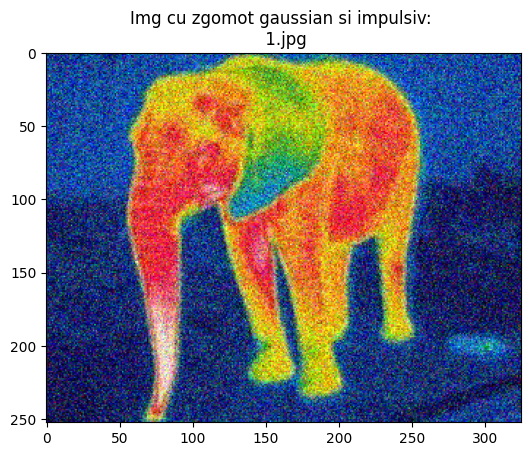

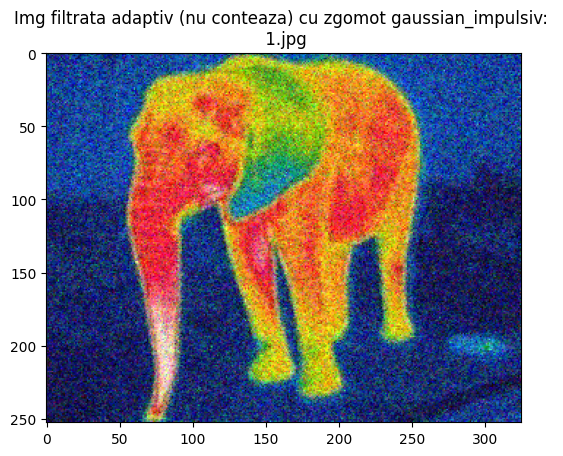

In [56]:
pathname = 'Images\\1.jpg'
img = io.imread(pathname)
display_image(img, 'Img originala', pathname)

img_noise_gauss = add_gaussian_noise(img, 40)
img_noise_impulsiv = add_impulsive_noise(img, 0.2, 0.2)
img_noise_gauss_impulsiv = add_impulsive_noise(add_gaussian_noise(img, 40), 0.2, 0.2)

display_image(img_noise_gauss, 'Img cu zgomot gaussian', pathname)
# gaussian normal
filter_type = 'normal'
noise_type = 'gaussian'
imgout = compute_image_choosing_filter_and_noise_type(img, img_noise_gauss, filter_type, noise_type)
display_image(imgout, 'Img filtrata {0} cu zgomot {1}'.format(filter_type,noise_type), pathname)

# gaussian adaptiv
filter_type = 'adaptiv'
noise_type = 'gaussian'
imgout = compute_image_choosing_filter_and_noise_type(img, img_noise_gauss, filter_type, noise_type)
display_image(imgout, 'Img filtrata {0} cu zgomot {1}'.format(filter_type,noise_type), pathname)


display_image(img_noise_impulsiv, 'Img cu zgomot impulsiv', pathname)
# impulsiv normal
filter_type = 'normal'
noise_type = 'impulsiv'
imgout = compute_image_choosing_filter_and_noise_type(img, img_noise_gauss, filter_type, noise_type)
display_image(imgout, 'Img filtrata {0} cu zgomot {1}'.format(filter_type,noise_type), pathname)

# impulsiv adaptiv
filter_type = 'adaptiv'
noise_type = 'impulsiv'
imgout = compute_image_choosing_filter_and_noise_type(img, img_noise_gauss, filter_type, noise_type)
display_image(imgout, 'Img filtrata {0} cu zgomot {1}'.format(filter_type,noise_type), pathname)

# gaussian_impulsiv
display_image(img_noise_gauss, 'Img cu zgomot gaussian si impulsiv', pathname)
filter_type = 'adaptiv (nu conteaza)'
noise_type = 'gaussian_impulsiv'
imgout = compute_image_choosing_filter_and_noise_type(img, img_noise_gauss, filter_type, noise_type)
display_image(imgout, 'Img filtrata {0} cu zgomot {1}'.format(filter_type,noise_type), pathname)

(253, 325, 3)
T1 = 70, T2 = 5


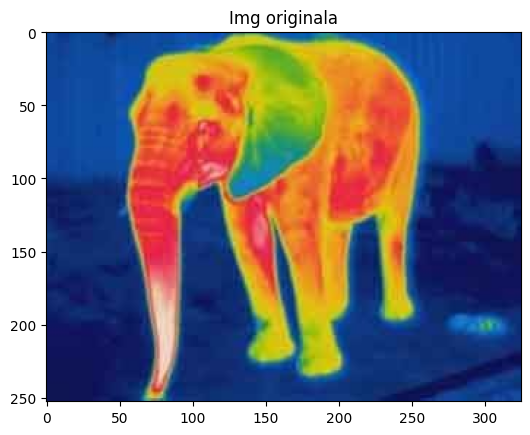

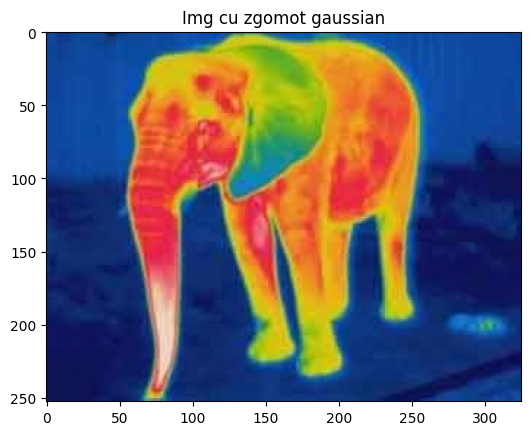

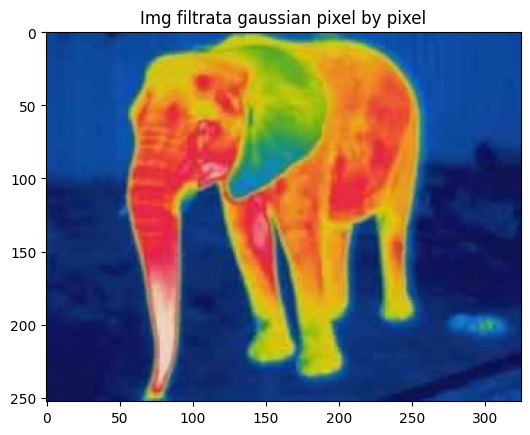

Results:
Gaussian points: 28244
Impulsive points: 26196
Normal points: 192235

Gaussian noise: 11.45%
Impulsive noise: 10.62%
Normal points: 11.45%
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
MSE for gaussian: 1.9351292186074796
NMSE for gaussian: 6.874398973802401e-08

#
#
#
#
#
#


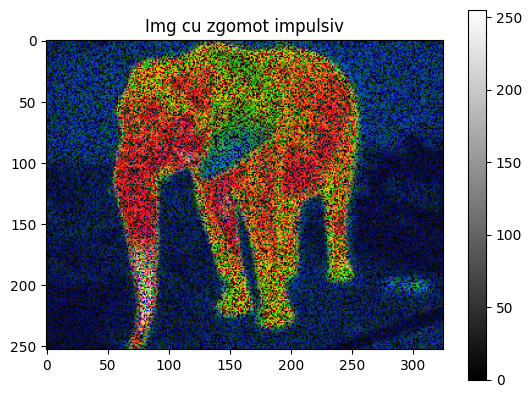

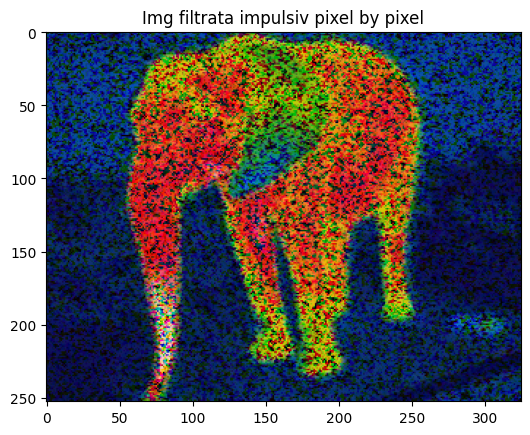

Results:
Gaussian points: 26591
Impulsive points: 75543
Normal points: 144541

Gaussian noise: 10.78%
Impulsive noise: 30.62%
Normal points: 10.78%
MSE for impulsive: 37.20495388669302
NMSE for impulsive: 1.6946147752414683e-06


In [143]:
# Example usage of Self-adaptive Weighted mean and Self-adaptive Weighted median filter
#                  ###### gaussian ######          ##### impulsive ##### 

pathname = 'Images\\1.jpg'
img = io.imread(pathname)
L,C,pl = np.shape(img)

if pl > 3:
    print("original image has also transparency \nsize was {0}".format(np.shape(img)))
    img=img[:,:,:3]
else:
    print(np.shape(img))

img=np.uint8(img)
T1, T2 = compute_thresholds(img)
print("T1 = {0}, T2 = {1}".format(T1,T2))

plt.figure(), plt.title("Img originala"), plt.imshow(img), plt.show()

# add gaussian noise
img_noise_gauss = add_gaussian_noise(img, 0.5)
plt.figure(), plt.title("Img cu zgomot gaussian"), plt.imshow(img_noise_gauss), plt.show()

# filter with pixel by pixel function
[imgout, gaussian_counter, impulsive_counter, normal_counter] = compute_image_adaptive_weighted_filter(img_noise_gauss, T1, T2)

# see results
plt.figure(), plt.title("Img filtrata gaussian pixel by pixel"), plt.imshow(imgout), plt.show()
print("Results:\nGaussian points: {0}\nImpulsive points: {1}\nNormal points: {2}".format(gaussian_counter, impulsive_counter, normal_counter))
print("\nGaussian noise: {0}%\nImpulsive noise: {1}%".format(round(gaussian_counter/(L*C*3)*100,2), round(impulsive_counter/(L*C*3)*100,2)))
print("Normal points: {0}%".format(round(gaussian_counter/(L*C*3)*100,2)))

# MSE, NMSE
print(type(imgout), type(img_noise_gauss))
MSE_gauss, NMSE_gauss = MSE(imgout, img_noise_gauss)
print("MSE for gaussian: {0}".format(MSE_gauss))
print("NMSE for gaussian: {0}".format(NMSE_gauss))

###########################################################################################
print("\n#\n#\n#\n#\n#\n#")

# add impulsive noise
img_noise_impulsive = add_impulsive_noise(img, 0.25, 0.25)
plt.figure(),plt.title("Img cu zgomot impulsiv") , plt.imshow(img_noise_impulsive, cmap='gray'),plt.colorbar(),plt.show()

# filter with pixel by pixel function
[imgout, gaussian_counter, impulsive_counter, normal_counter] = compute_image_adaptive_weighted_filter(img_noise_impulsive, T1, T2)

# see results
plt.figure(), plt.title("Img filtrata impulsiv pixel by pixel"), plt.imshow(imgout), plt.show()
print("Results:\nGaussian points: {0}\nImpulsive points: {1}\nNormal points: {2}".format(gaussian_counter, impulsive_counter, normal_counter))
print("\nGaussian noise: {0}%\nImpulsive noise: {1}%".format(round(gaussian_counter/(L*C*3)*100,2), round(impulsive_counter/(L*C*3)*100,2)))
print("Normal points: {0}%".format(round(gaussian_counter/(L*C*3)*100,2)))

# MSE, NMSE
MSE_impulsive, NMSE_impulsive = MSE(imgout, img_noise_impulsive)
print("MSE for impulsive: {0}".format(MSE_impulsive))
print("NMSE for impulsive: {0}".format(NMSE_impulsive))